<a href="https://colab.research.google.com/github/nlptrinh/CinnamonAI/blob/master/Anomaly_detection_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/CinnamonAI")

In [54]:
!pwd

/content/drive/My Drive/CinnamonAI


In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi,e

In [0]:
from scipy.io import loadmat
from scipy.io.arff import loadarff
import numpy as np
import pandas as pd
from collections import OrderedDict

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc, make_scorer
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.externals.joblib import Parallel, delayed

In [0]:
import seaborn as sns
sns.set(font_scale=1.5)

# **Using PCA for detection**

**Load data and inspect**

In [0]:
data = loadmat('data/cardio.mat')

In [60]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [0]:
X = data['X']
y = data['y']

In [62]:
X.shape, y.shape

((1831, 21), (1831, 1))

In [0]:
y = y.squeeze()

**Scale data to have zero mean and unit standard deviation**

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Split into test and trainign data sets¶**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [66]:
len(X_train)

1647

In [0]:
def score(a, b):
    """Normalized differnece of squares between a and b."""

    loss = np.sum((a-b)**2, axis=1)
    loss = (loss-loss.min())/(loss.max() - loss.min())
    return loss

In [0]:
def fit(n, X):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    X_pca_inverse = pca.inverse_transform(X_pca)
    y_score = score(X, X_pca_inverse)
    return (n, y_score)

In [0]:
search = Parallel(n_jobs=-1)(delayed(fit)(n, X_train) for n in range(2,X.shape[1]))

In [0]:
scores =  np.array([(n, average_precision_score(y_train, y_score)) for (n, y_score) in search])

In [71]:
best = max(scores, key=lambda x: x[1])
best

array([2.        , 0.43997947])

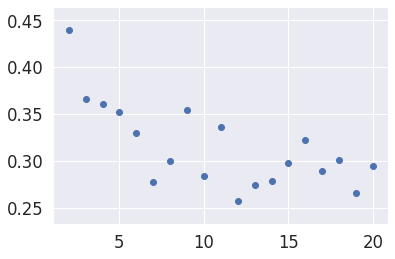

In [72]:
plt.scatter(scores[:, 0], scores[:, 1])
pass

In [0]:
n = int(best[0])
n, y_score = fit(n, X_test)

In [74]:
average_precision_score(y_test, y_score)

0.6526929839638869

In [0]:
df = pd.DataFrame(dict(score=y_score, y=y_test))

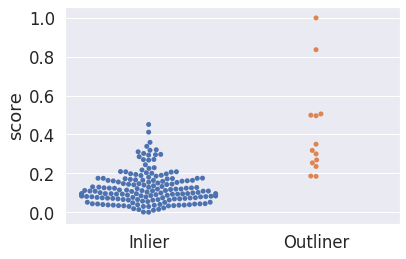

In [76]:
g = sns.swarmplot(data=df, x='y', y='score')
g.set_xticklabels(['Inlier', 'Outliner'])
g.set_xlabel('')
pass

# **Visualizing data**

In [0]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

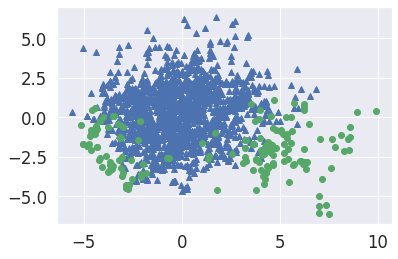

In [78]:
plt.plot(X_pca[y_train == 0,0],X_pca[y_train==0,1],'b^')
plt.plot(X_pca[y_train == 1,0],X_pca[y_train==1,1],'go')

# **Gaussian Distribution**

In [0]:
data = loadmat('data/cardio.mat')

In [0]:
X = data['X']
y = data['y']

In [0]:
scaler = StandardScaler()

In [0]:
X = scaler.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [0]:
def estimateGaussian(X):
    mu = np.sum(X,axis = 0)/X.shape[0]
    sigma2 = np.sum((X-mu)**2,axis = 0)/X.shape[0] 
    return mu,sigma2
def multivariateGaussian(X,mu,sigma2):
    sigma2 = np.diag(sigma2)
    k = len(mu)
    p = (2*pi)**(-k/2)*np.linalg.det(sigma2)**(-0.5)*np.exp(-0.5*((((X-mu))@np.linalg.inv(sigma2))@(X-mu).T))
    return np.diag(p)
def selectThresholds(y,p):
    bestEpsilon = 0
    bestF1 = 0
    f1_score = 0
    stepsize = (max(p)-min(p))/10000
    for i in np.arange(min(p),max(p),stepsize):
        prediction = (p < i).astype(int)
        prediction = prediction.reshape(prediction.shape[0],1)
        fp = np.sum((prediction == 1) * (y == 0))

        fn = np.sum((prediction == 0) * (y == 1))
        tp = np.sum((prediction == 1) * (y == 1))

        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        f1_score = 2 * prec * rec / (prec + rec)
        if f1_score > bestF1:
            bestF1 = f1_score
            bestEpsilon = i
    return bestEpsilon,bestF1

In [0]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [0]:
mu,sigma2 = estimateGaussian(X_train)

In [0]:
p = multivariateGaussian(X_train,mu,sigma2)

In [88]:
epsilon,F1= selectThresholds(y_train,p)
epsilon,F1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


(8.177831951996897e-14, 0.534453781512605)

In [0]:
p_test = multivariateGaussian(X_test,mu,sigma2)

In [90]:
pre = p_test < epsilon
pre

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False, False,  True,
       False,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False,  True,  True, False, False, False,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
       False,  True,

In [91]:
from sklearn.metrics import f1_score
f1_score(pre,y_test),accuracy_score(pre,y_test)

(0.44444444444444436, 0.8097826086956522)

# **Gaussian Mixer Models**

In [0]:
from scipy.stats import multivariate_normal

In [0]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.reg_cov = 1e-6*np.identity(self.m)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ (np.cov(X.T)+self.reg_cov)  for _ in range(self.k) ] 

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True) + self.reg_cov

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
#             likelihood[:,i] = multivariateGaussian(X,self.mu[i],self.sigma[i])
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [0]:
data = loadmat('data/cardio.mat')
X = data['X']
y = data['y']

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [0]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [0]:
gmm = GMM(k=1, max_iter=10)
gmm.fit(X_train)
pre = gmm.predict(X_train)

# **GMM with Sklearn for anomaly detection**

In [0]:
data = loadmat('data/cardio.mat')
X = data['X']
y = data['y']

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [0]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
gmm = GaussianMixture(n_components=1)

In [105]:
gmm.fit(X_normally)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
score = gmm.score_samples(X_train)

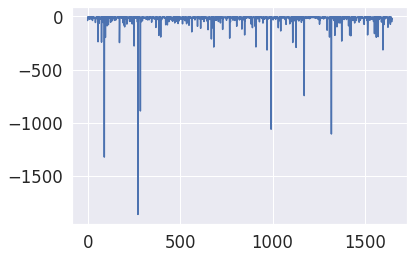

In [107]:
plt.plot(score)

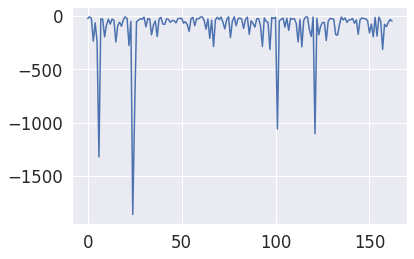

In [108]:
anomaly_score = score[np.where(y_train == 1)[0]]
plt.plot(anomaly_score)

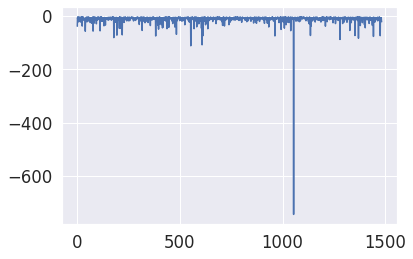

In [109]:
nomaly_score = score[np.where(y_train == 0)[0]]
plt.plot(nomaly_score)

In [110]:
epsilon,F1= selectThresholds(y_train,score)
epsilon,F1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


(-26.127970275301777, 0.6989247311827957)

In [0]:
test_score = gmm.score_samples(X_test)
pre = (test_score < epsilon).astype(int)

In [112]:
f1_score(pre,y_test)

0.6666666666666666

In [113]:
accuracy_score(pre,y_test)

0.9293478260869565